In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


from sklearn.model_selection import train_test_split

In [2]:
# Step 1: Load the CSV files
viral_activity_df = pd.read_csv(r"C:\Users\ek00049\Downloads\data\nation_wastewater_surveillance_viral_activity_level_over_time_data.csv")

deaths_df = pd.read_csv(r"C:\Users\ek00049\Downloads\data\data_table_for_cumulative_deaths_and_total_deaths_.csv")


In [3]:
deaths_df.drop(columns=["Geography", "Death Data As Of"], axis=1, inplace =True)

In [4]:
deaths_df.columns

Index(['Date', 'Cumulative Deaths', 'Total Deaths Per 100000 (age-adjusted)'], dtype='object')

In [5]:
viral_activity_df["Date"] = pd.to_datetime(viral_activity_df["Date"])

In [6]:
deaths_df["Date"] = pd.to_datetime(deaths_df["Date"])

In [7]:
deaths_df.rename(columns={"Total Deaths Per 100000 (age-adjusted)": "deaths_per_100K_age_adjusted"}, inplace=True)

In [8]:
deaths_df["deaths_per_100K_age_adjusted"] = pd.to_numeric(deaths_df["deaths_per_100K_age_adjusted"])

In [9]:
print("Date types in viral activity data",viral_activity_df.dtypes)

Date types in viral activity data Date                    datetime64[ns]
Viral Activity Level           float64
dtype: object


In [10]:
print("Date types in deaths data",deaths_df.dtypes)

Date types in deaths data Date                            datetime64[ns]
Cumulative Deaths                        int64
deaths_per_100K_age_adjusted           float64
dtype: object


In [11]:
df = deaths_df.merge(viral_activity_df, on = "Date", how="inner")

In [12]:
df = df.sort_values(by="Date")

In [13]:
df.isna().sum()

Date                            0
Cumulative Deaths               0
deaths_per_100K_age_adjusted    0
Viral Activity Level            0
dtype: int64

In [14]:
df.dtypes

Date                            datetime64[ns]
Cumulative Deaths                        int64
deaths_per_100K_age_adjusted           float64
Viral Activity Level                   float64
dtype: object

In [15]:
df["month"] = df["Date"].dt.month

In [16]:
df

,Date,Cumulative Deaths,deaths_per_100K_age_adjusted,Viral Activity Level,month
164,2022-01-01,848853,212.3,16.68,1
163,2022-01-08,863980,216.1,24.63,1
162,2022-01-15,883060,220.8,23.45,1
161,2022-01-22,904397,226.2,20.97,1
160,2022-01-29,925365,231.4,15.15,1
...,...,...,...,...,...
4,2025-01-25,1219593,305.5,4.55,1
3,2025-02-01,1220443,305.7,4.56,2
2,2025-02-08,1221099,305.9,4.46,2
1,2025-02-15,1221596,306.0,4.11,2


In [17]:
# Derive rolling averages
df['rolling_avg_viral_activity'] = df['Viral Activity Level'].rolling(window=7).mean()


# Derive lag features
df['lagged_viral_activity'] = df['Viral Activity Level'].shift(1)

df['percent_change_viral_activity'] = df['Viral Activity Level'].pct_change() * 100

# Interaction features
df['viral_deaths_interaction'] = df['Viral Activity Level'] * df['deaths_per_100K_age_adjusted']



# Dropping missing values created by rolling and lag features
df = df.dropna()

In [18]:
df.columns

Index(['Date', 'Cumulative Deaths', 'deaths_per_100K_age_adjusted',
       'Viral Activity Level', 'month', 'rolling_avg_viral_activity',
       'lagged_viral_activity', 'percent_change_viral_activity',
       'viral_deaths_interaction'],
      dtype='object')

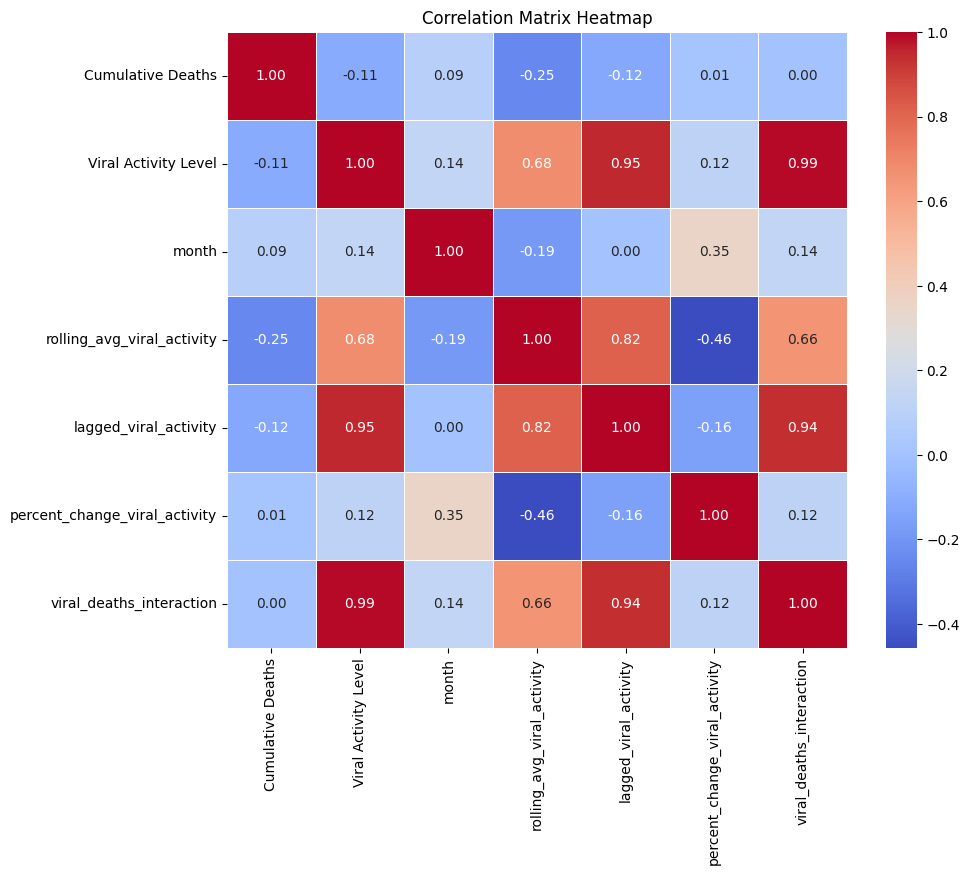

In [19]:
corr_features = ['Cumulative Deaths',  'Viral Activity Level', 
                 'month', 'rolling_avg_viral_activity',
                 'lagged_viral_activity', 'percent_change_viral_activity', 'viral_deaths_interaction']

# Calculate the correlation matrix
correlation_matrix = df[corr_features].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [20]:
df.drop(columns= ["deaths_per_100K_age_adjusted"], axis=1, inplace=True)

C:\Users\ek00049\AppData\Local\Temp\1\ipykernel_8496\78548713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns= ["deaths_per_100K_age_adjusted"], axis=1, inplace=True)


c:\Users\ek00049\AppData\Local\anaconda3\envs\dmi_production\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Absolute Error (MAE): 51550.12325000011
R-squared (R2) Score: 0.39502655627439376


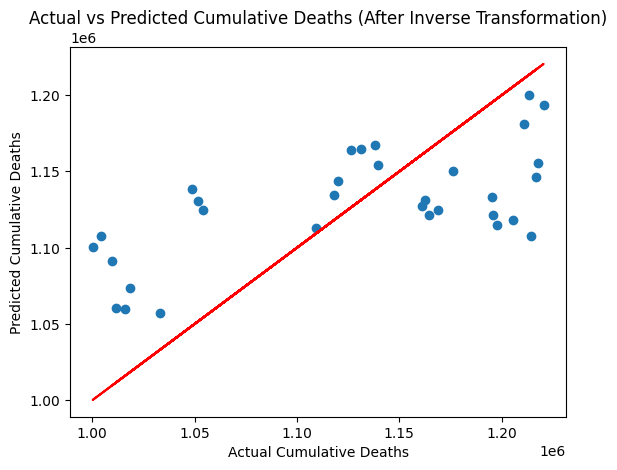

In [21]:


# Assuming X and y are already defined
# Min-Max Scaling for better model performance
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = df[['Viral Activity Level', 'month', 'rolling_avg_viral_activity', 
        'lagged_viral_activity', 'percent_change_viral_activity', 
        'viral_deaths_interaction']]
y = df['Cumulative Deaths']

# Fit and transform the independent features (X)
X_scaled = scaler_X.fit_transform(X)

# Fit and transform the dependent variable (y)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))  # Reshape y into a 2D array

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Train a regression model (Random Forest Regressor for demonstration)
model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Reverse the Min-Max Scaling on predictions and actual values
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform actual values
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))  # Inverse transform predicted values

# Evaluate the model
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

# Output the results
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

# Visualizing predictions vs actuals (after reverse transformation)
plt.scatter(y_test_original, y_pred_original)
plt.plot(y_test_original, y_test_original, color='red')  # Line for perfect prediction
plt.xlabel("Actual Cumulative Deaths")
plt.ylabel("Predicted Cumulative Deaths")
plt.title("Actual vs Predicted Cumulative Deaths (After Inverse Transformation)")
plt.show()


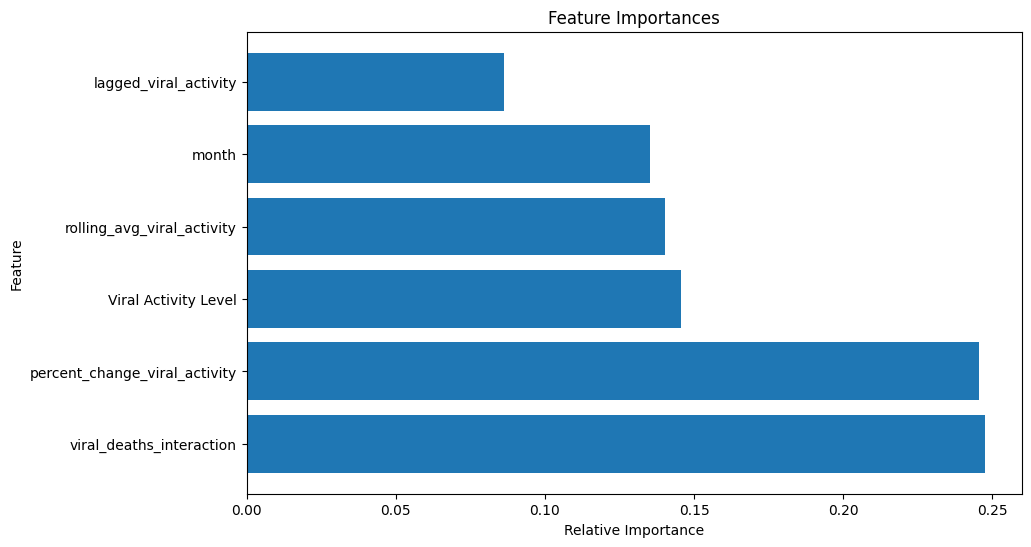

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances from the trained model
importances = model.feature_importances_

# Get the feature names (assuming X contains the feature names)
features = X.columns  # If X is a DataFrame with named columns
# If X is a NumPy array, you'll need to manually define the feature names like so:
# features = ['Feature1', 'Feature2', 'Feature3', ...] 

# Sort the features by importance
indices = np.argsort(importances)[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(features)), importances[indices], align="center")
plt.yticks(range(len(features)), np.array(features)[indices])
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.show()
